Import Libraries

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom
from skimage.measure import label, regionprops
from skimage import exposure
from czifile import imread
from cellpose import models, io, plot 
model = models.Cellpose(model_type='cyto')

c:\Users\sj1205\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

Define Sub Functions

In [19]:
def display_image(image, path):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(path)
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image):
    """Extract channels from the image."""
    return image[0], image[1], image[2]

def otsu_thresholding(channel):
    """Apply Otsu's thresholding and morphological closing to the channel."""
    threshold_value = threshold_otsu(channel)
    binary_image = channel > threshold_value
    closed_image = binary_closing(binary_image, disk(3))
    labeled_image = label(closed_image)
    return labeled_image

Main Function

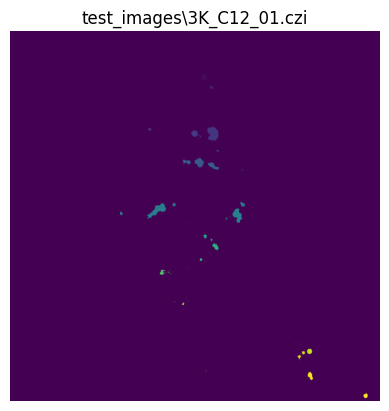

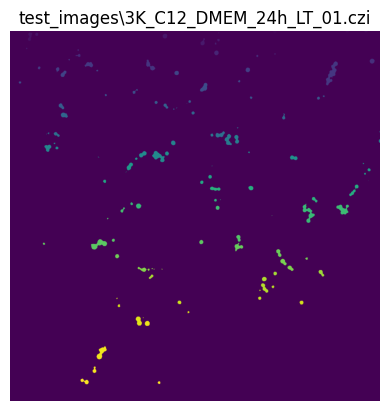

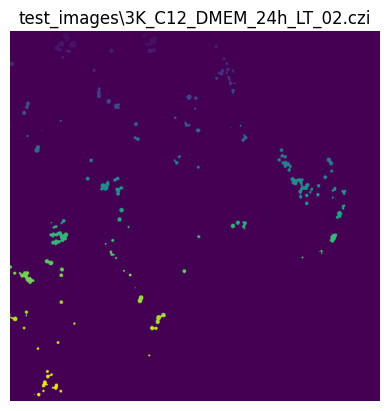

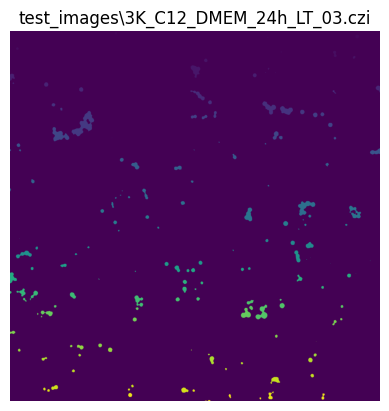

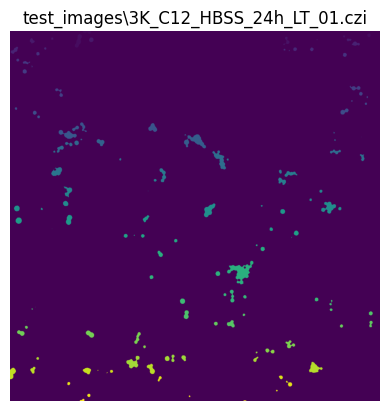

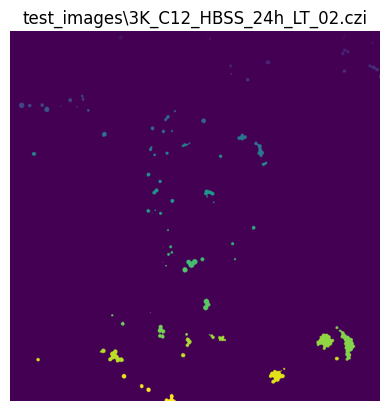

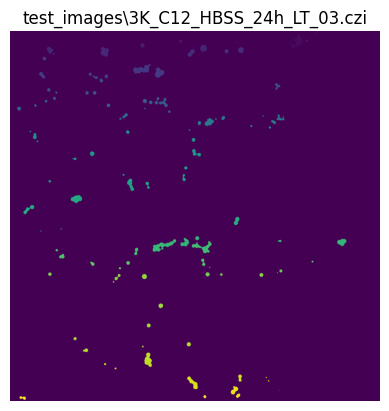

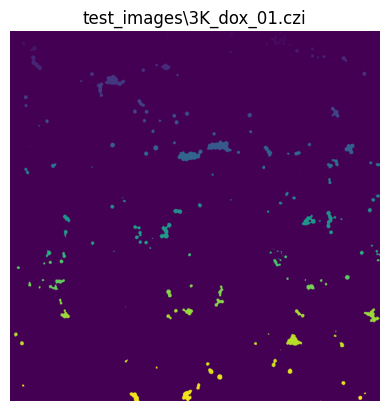

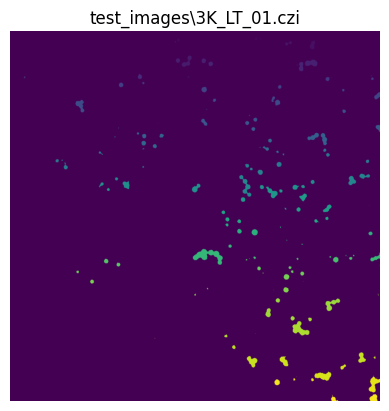

In [20]:
def main(image_folder):

    images_to_analyze = extract_image_paths(image_folder)

    # Iterate over each image
    for path in images_to_analyze:
        image = read_image(path).squeeze()
        deep_red_channel, C12_channel, green_channel = extract_channels(image)
        new_image = otsu_thresholding(deep_red_channel)
        display_image(new_image, path)


if __name__ == "__main__":
    image_folder = 'test_images'
    main(image_folder)